In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

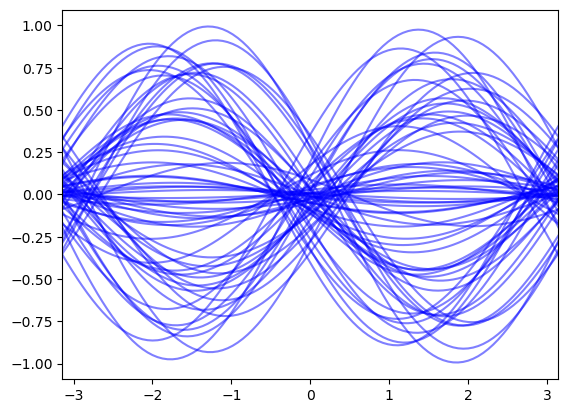

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [46]:
from emile_np import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
num_params = sum(p.numel() for p in neuralprocess.parameters())
print('Number of parameters: %d' % num_params)
print(neuralprocess)

Number of parameters: 20702
NeuralProcess(
  (xy_to_r): Encoder(
    (input_to_hidden): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (r_to_mu_sigma): MuSigmaEncoder(
    (r_to_hidden): Linear(in_features=50, out_features=50, bias=True)
    (hidden_to_mu): Linear(in_features=50, out_features=50, bias=True)
    (hidden_to_sigma): Linear(in_features=50, out_features=50, bias=True)
  )
  (xz_to_y): Decoder(
    (xz_to_hidden): Sequential(
      (0): Linear(in_features=51, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU(inplace=True)
    )
    (hidden_to_mu): Linear(in_features=50, out_features

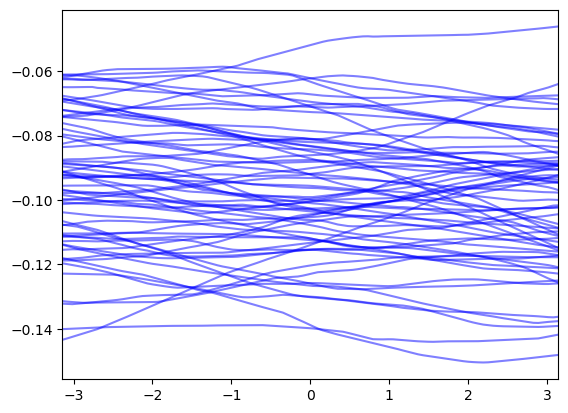

In [14]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [15]:
from torch.utils.data import DataLoader
from emile_training import NeuralProcessTrainer

batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 4.920
iteration 400, loss 7.976
iteration 600, loss 4.085
iteration 800, loss 7.585
iteration 1000, loss 7.331
Epoch: 0, Avg_loss: 3.923651127550751
iteration 1200, loss 5.054
iteration 1400, loss 6.576
iteration 1600, loss 2.029
iteration 1800, loss 5.909
iteration 2000, loss 0.290
Epoch: 1, Avg_loss: 2.0742018540063873
iteration 2200, loss 7.487
iteration 2400, loss 2.419
iteration 2600, loss 4.855
iteration 2800, loss -1.344
iteration 3000, loss 0.159
Epoch: 2, Avg_loss: 1.912067593075335
iteration 3200, loss -2.315
iteration 3400, loss -3.204
iteration 3600, loss 1.879
iteration 3800, loss -1.721
iteration 4000, loss 7.066
Epoch: 3, Avg_loss: 1.8694527184776961
iteration 4200, loss 1.830
iteration 4400, loss 0.723
iteration 4600, loss 6.515
iteration 4800, loss -1.899
iteration 5000, loss 0.746
Epoch: 4, Avg_loss: 1.796594413947314
iteration 5200, loss 2.033
iteration 5400, loss 4.376
iteration 5600, loss -0.809
iteration 5800, loss 2.467
iteration 6000, loss -1

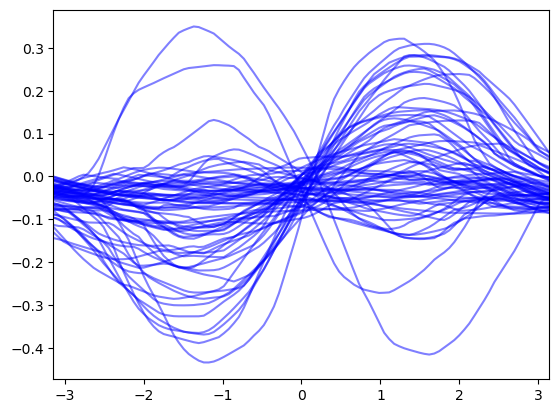

In [16]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)


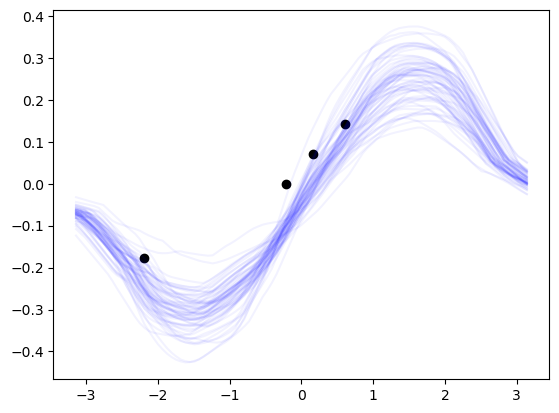

In [45]:
from emile_utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')